In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from data import *
from utils import *
from NMF import *
import time
import pandas as pd
import seaborn

2023-02-16 19:19:31.304592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martilud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Convergence experiment
---

We generate data, $2500$ of all types of data, with $0$ and $1$ digits. We select deterministic weights equal to $1/2$, and preselect $d = 32$. We do all experiments with the same data. The loss we show is the respective loss of the different methods. For all methods, we only show convergence of the first source. For ANMF we select the batch size of the adversarial data to be $100$ for all experiments. 

In [2]:
np.random.seed(0)
mnist = MNIST()
Ms = [0,1]
M = len(Ms)
N_adv = 2500
N_sup = 2500
N_V = 2500
N_sup_test = 500

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "det", weights = [1.0/M] * M)
V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

In [3]:
# Convergence of NMF 
plt.rcParams.update({'font.size': 14})

batch_sizes = [100, 250, 1250, 2500]
linestyles = ['dashdot']*10
times = []
for i,b in enumerate(batch_sizes):
    tick = time.time()
    nmf = NMF(d = 32, loss = "square", epochs = 100, batch_size = b, mu_W = 1e-10, mu_H = 1e-10)
    loss_std = nmf.fit_std(U_r = U_sup[0],conv = True)
    tock = time.time()
    times.append(tock-tick)

    # Check if loss is non-decreasing
    #print(np.abs(np.flip(loss_adv[1:]) - np.sort(loss_adv[1:])) < 1e-10)
    plt.plot(np.arange(1,101), loss_std[1:],label = f"Batch size = {b/U_sup[0].shape[1]} N", linestyle = linestyles[i])
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Stochastic Multiplicative Update for NMF")
plt.grid()
plt.savefig("std_conv32.png")
plt.show()
print(times)

TypeError: __init__() got an unexpected keyword argument 'batch_size_r'

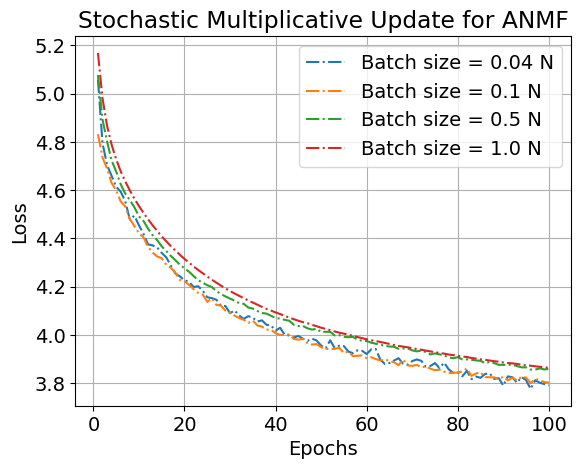

[9.649808168411255, 8.541690111160278, 8.167015075683594, 9.231486797332764]


In [6]:
# Convergence of Adversrial NMF
plt.rcParams.update({'font.size': 14}) 

batch_size_r = [100,250,1250,2500]
batch_size_z = [100,100,100,2500]
linestyles = ['dashdot']*10
times = []
for i,b in enumerate(batch_size_r):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [32,32], loss = "square", epochs = 100, mu_W = 1e-10, mu_H = 1e-10, batch_size_r = batch_size_r[i], batch_size_z = batch_size_z[i], taus = [0.1,0.1])
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_std, loss_adv = nmf_sep.NMFs[0].fit_adv(U_r = U_sup[0], U_z = U_z[0], conv = True)
    tock = time.time()
    times.append(tock-tick)

    plt.plot(np.arange(1,101), loss_adv[1:],label = f"Batch size = {b/U_sup[0].shape[1]} N", linestyle = linestyles[i])
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Stochastic Multiplicative Update for ANMF")
plt.grid()
plt.savefig("adv_conv32.png")
plt.show()
print(times)

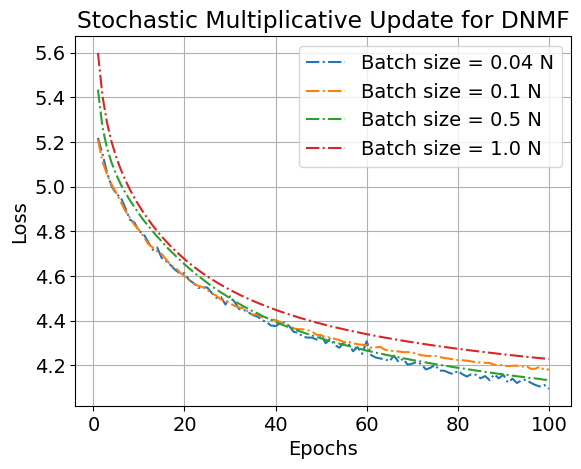

[5.627123832702637, 4.7933669090271, 4.667273998260498, 4.644389867782593]


In [37]:
# Convergence of discriminative NMF
plt.rcParams.update({'font.size': 14}) 

batch_sizes = [100, 250, 1250, 2500]
linestyles = ['dashdot']*10
times = []
ds = [32,32]
for i,b in enumerate(batch_sizes):
    tick = time.time()
    nmf = NMF(d = np.sum(ds), ds = ds, loss = "square", epochs = 100, mu_W = 1e-10, mu_H = 1e-10, batch_size_sup = b)
    loss_sup = nmf.fit_sup(U_r = U_sup, V = V_sup, conv = True)
    tock = time.time()
    times.append(tock-tick)
    plt.plot(np.arange(1,101),loss_sup[0,1:],label = f"Batch size = {b/U_sup[0].shape[1]} N", linestyle = linestyles[i])
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Stochastic Multiplicative Update for DNMF")
plt.grid()
plt.savefig("sup_conv32.png")
plt.show()
print(times)

We see that for all methods converge, and smaller batch sizes tend to yield faster convergence. Selecting the batch sizes too small can lead to slower convergence and too much randomness. It is also interesting to see that standard NMF converges to a smaller loss than DNMF, because DNMF. This is to be expected as DNMF has to fit the basises while also splitting mixed data, while standard NMF only has to learn bases.


Data rich experiment
---

In this experiment we want to test the proposed methods in a setting where we have a lot of both weak and strong supervised data to see how the data settings compare. We test this on $0$ and $1$ digits, as NMF performs relatively well in this situation. We select $2500$ of each source, $2500$ mixed data and $2500$ strong supervised data. The mixed data is generated so that none of the mixed images are the same as the source images. In other words, no observed data from $\mathbb{P}_{U_i}$ is used to generate observed data from $\mathbb{P}_V$.


In [18]:
# Parameters for experiment
np.random.seed(0)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_adv = 2500
N_V = 2500
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-4
mu_H = 1e-4

epochs_std = 50
epochs = 50
test_epochs = 100
batch_size_r = 500
batch_size_sup = 500
batch_size_z = 100

Ds = [32,64,128,256]

probs = ["std", "adv","sup", "exem"]

dfs = []
for i in range(len(probs)):
    dfs.append(pd.DataFrame(columns=[ "norm_means", "norm_stds","psnrs", "psnr_means", "psnr_stds"]))
meta_df = pd.DataFrame(columns=["Ms"])

taus = [0.0, 0.1, 0.0,0.0]


for ex in range(number_of_experiments):
    print(ex)
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()
    mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    U_r = []
    for i in range(M):
        U_r.append(np.copy(mnist.x_r_train[i].reshape((mnist.Ns_adv[i],784)).T))
    V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    # Each problem, each source, each data
    norms = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
    norm_means = np.zeros((len(probs), M, len(Ds))) 
    norm_stds = np.zeros((len(probs), M, len(Ds)))
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
    mean_psnrs = np.zeros((len(probs), M, len(Ds)))
    std_psnrs = np.zeros((len(probs), M, len(Ds)))
    for j,d in enumerate(Ds):
        for i, prob in enumerate(probs):

            # Fit
            sep = NMF_separation(ds = [d] * M, taus = [taus[i]]*M, 
                epochs = epochs_std if prob == "std" else epochs,prob = prob,loss = "square", 
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs,
                batch_size_r = batch_size_r, batch_size_z = batch_size_z, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])
            
            sep.fit(U_r = U_r, V = V, U_sup = U_sup, V_sup = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)


            # Separate
            out = sep.separate(V_test)

            # Measure quality
            norms[i,:,j,:] = np.linalg.norm(out - U_test, 2, axis = 0)**2
            norm_means[i,:, j] = np.mean(norms[i,:,j], axis = -1)
            norm_stds[i,:, j] = np.std(norms[i,:,j], axis = -1)
            psnrs[i,:,j,:] = PSNR(U_test,out)
            mean_psnrs[i, :, j] = np.mean(psnrs[i,:,j], axis = -1)
            std_psnrs[i, :, j] = np.std(psnrs[i,:,j], axis = -1)
    for i in range(len(probs)):
        dfs[i].loc[ex] = { "norm_means" : norm_means[i], "norm_stds": norm_stds[i], "psnrs" : psnrs[i], "psnr_means" : mean_psnrs[i], "psnr_stds": std_psnrs[i]}
    meta_df.loc[ex] = {"Ms" : Ms}

0


(2, 4, 1000)


<AxesSubplot: >

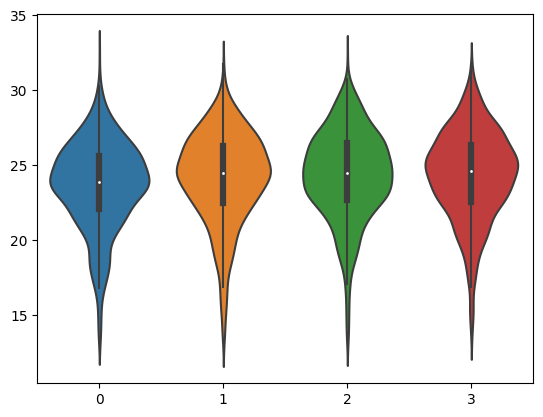

In [39]:
print(dfs[0]["psnrs"][0].shape)
seaborn.violinplot(data = dfs[0]["psnrs"][0][1,:,:].T)
#seaborn.violinplot(data = psnrs[0,0,1,:])

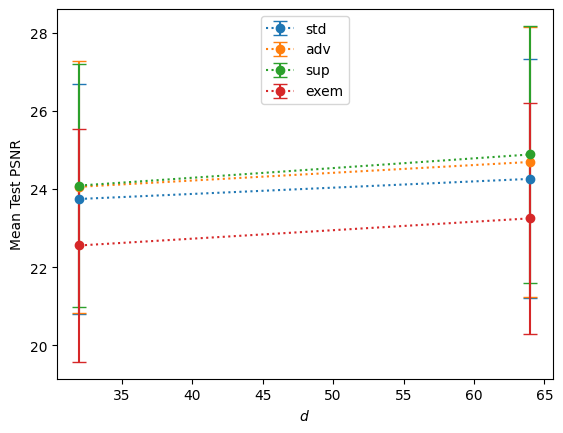

In [5]:
# 2500 datapoints, 
#print(meta_df["Ms"])
for i, prob in enumerate(probs):
    plt.errorbar(Ds, np.median(dfs[i]["psnr_means"])[0], marker = "o", yerr = np.concatenate(dfs[i]["psnr_stds"])[0], label = prob, fmt = ":", capsize = 5, capthick = 1)
    #plt.plot(Ds, np.mean(dfs[i]["psnr_means"])[0], marker = "o", label = prob)
    #plt.errorbar(Ds, np.mean(dfs[i]["psnr_means"])[0], marker = "o", yerr = np.mean(dfs[i]["psnr_stds"]), label = prob, fmt = ":", capsize = 5, capthick = 1)
plt.xlabel(r"$d$")
plt.ylabel("Mean Test PSNR")
plt.legend()
plt.show()

In [18]:
mnist = MNIST()
Ms = [0,1]
M = len(Ms)
N_adv = 500
N_sup = 100
N_V = 1000
N_sup_test = 1000

mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "deterministic", weights = [1.0/M]*M)
U_r = []
for i in range(M):
    U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "dir", weights = [100.0] * M)
V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

d_dict = {"name": 'ds', "dist": lambda: [64, 64]}
mu_H_dict = {"name": 'mu_H', "dist": lambda: np.power(10,np.random.uniform(-10,0))}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,0))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(10,50)}
batch_size_r_dict = {"name": 'batch_size_r', "dist": lambda: np.random.choice([250,500], replace = True)}
batch_size_z_dict = {"name": 'batch_size_z', "dist": lambda: np.random.choice([50,100,250], replace = True)}
batch_size_sup_dict = {"name": 'batch_size_sup', "dist": lambda: np.random.choice([50], replace = True)}
wse_dict = {"name": 'warm_start_epochs', "dist": lambda: np.random.randint(1,10)}
taus_dict = {"name": 'taus', "dist": lambda: [np.random.uniform(0.0,0.4), np.random.uniform(0.0,0.5)]}
betas_dict = {"name": 'betas', "dist": lambda: [np.random.uniform(0.1,0.9), np.random.uniform(0.1,0.9)]} 

prob_dict = {"name": 'prob', "dist" : lambda: "std"}

param_dicts = [d_dict, 
    mu_H_dict, 
    prob_dict, 
    mu_W_dict, 
    epochs_dict, 
    batch_size_r_dict, 
    batch_size_z_dict, 
    batch_size_sup_dict,
    wse_dict, 
    taus_dict,
    betas_dict,
]

rs = random_search(NMF_separation, param_dicts, N_ex = 10, cv = 0)

rs.fit(U_r = U_r, V = V, U_sup= U_sup, V_sup = V_sup)



{'ds': [64, 64], 'mu_H': 0.0384233696933953, 'prob': 'std', 'mu_W': 3.382470193745497e-05, 'epochs': 13, 'batch_size_r': 500, 'batch_size_z': 100, 'batch_size_sup': 50, 'warm_start_epochs': 1, 'taus': [0.11846067633211557, 0.18649026866684515], 'betas': [0.20475459523783127, 0.2501554188904981]} 24.19774847152492
{'ds': [64, 64], 'mu_H': 3.942740507506188e-08, 'prob': 'std', 'mu_W': 0.021709079052332072, 'epochs': 49, 'batch_size_r': 250, 'batch_size_z': 250, 'batch_size_sup': 50, 'warm_start_epochs': 3, 'taus': [0.0857156292720585, 0.04676739795545837], 'betas': [0.5575593970660577, 0.3086947001154545]} 24.266694401792424
{'ds': [64, 64], 'mu_H': 8.947199171186973e-06, 'prob': 'std', 'mu_W': 0.0016339591207192759, 'epochs': 43, 'batch_size_r': 250, 'batch_size_z': 100, 'batch_size_sup': 50, 'warm_start_epochs': 4, 'taus': [0.11863147840049125, 0.16377825591966094], 'betas': [0.4113347509654317, 0.5207630503464928]} 24.475510558231775
{'ds': [64, 64], 'mu_H': 0.020852549400505665, 'pro

In [19]:
print(np.mean(rs.best_model.eval(U_test[:,:,:],V_test[:,:], "psnr")))

23.87556135699443


In [1]:
mnist = MNIST()
Ms = [0,1]
M = len(Ms)
N_adv = 1000
N_sup = 100
N_V = 1000
N_sup_test = 500

mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "deterministic", weights = [1.0/M]*M)
U_r = []
for i in range(M):
    U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "dir", weights = [100.0] * M)
V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

NameError: name 'MNIST' is not defined

In [3]:
from NMF import *
d_dict = {"name": 'ds', "dist": lambda: [np.random.randint(64,65), np.random.randint(64,65)]}
mu_H_dict = {"name": 'mu_H', "dist": lambda: np.power(10,np.random.uniform(-10,2))}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,2))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(10,50)}
batch_size_r_dict = {"name": 'batch_size_r', "dist": lambda: np.random.choice([250,500,1000], replace = True)}
batch_size_z_dict = {"name": 'batch_size_z', "dist": lambda: np.random.choice([50,100,250], replace = True)}
wse_dict = {"name": 'warm_start_epochs', "dist": lambda: np.random.randint(10,50)}
taus_dict = {"name": 'taus', "dist": lambda: [np.random.uniform(0.0,0.5)]*M} 

prob_dict = {"name": 'prob', "dist" : lambda: "adv"}

param_dicts = [d_dict, 
    mu_H_dict, 
    prob_dict, 
    #mu_W_dict 
    #epochs_dict, 
    #batch_size_r_dict, 
    #batch_size_z_dict, 
    #wse_dict, 
    #taus_dict]
]

rs = random_search(NMF_separation, param_dicts, N_ex = 20)

rs.fit(U_r = U_r, V = V, U_test = U_test, V_test = V_test)


NameError: name 'U_z' is not defined

0


In [200]:
#print(np.mean(dfs[0]["psnr_means"]))
#print(np.concatenate(dfs[0]["psnr_means"]))
print(dfs[0]["psnr_stds"])


0    [[3.139533453260224, 2.896510075560397, 2.9390...
Name: psnr_stds, dtype: object


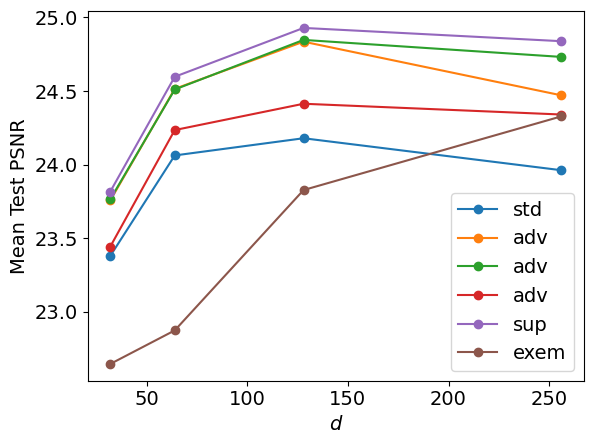

In [230]:
m = [np.array([1,2]),np.array([1,2]),np.array([1,2])]
b = np.copy(m)
print(m)


[array([1, 2]), array([1, 2]), array([1, 2])]


- Gjør eksperiemnt for ett valg av siffer.
- Plott forskjellen mellom foreslått og supervised, i steden for PSNR.

0     [4, 8]
1     [0, 1]
2     [0, 2]
3     [5, 2]
4     [6, 8]
5     [5, 2]
6     [9, 8]
7     [7, 0]
8     [5, 4]
9     [8, 4]
10    [3, 1]
11    [3, 8]
12    [9, 3]
13    [3, 6]
14    [3, 9]
15    [3, 0]
16    [6, 3]
17    [8, 9]
18    [5, 9]
19    [0, 3]
20    [7, 3]
21    [2, 6]
22    [5, 3]
23    [2, 3]
24    [5, 8]
25    [4, 6]
26    [6, 8]
27    [0, 9]
28    [2, 4]
29    [5, 2]
30    [6, 5]
31    [1, 2]
32    [1, 0]
33    [2, 9]
34    [8, 2]
35    [3, 5]
36    [4, 2]
37    [5, 3]
38    [5, 4]
39    [6, 0]
40    [7, 9]
41    [2, 8]
42    [8, 6]
43    [5, 9]
44    [1, 9]
45    [7, 8]
46    [6, 5]
47    [4, 6]
48    [8, 9]
49    [4, 2]
Name: Ms, dtype: object


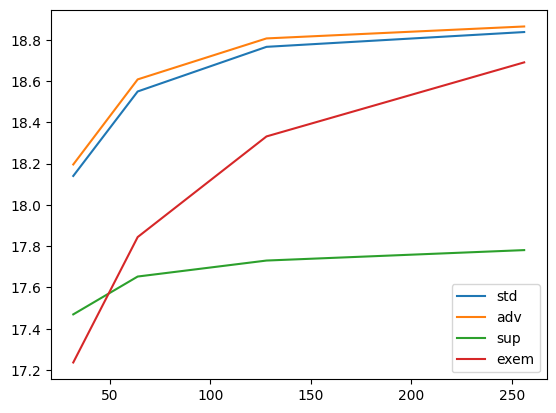

In [47]:
# 1000 datapoints, 
print(meta_df["Ms"])
for i, prob in enumerate(probs):
    plt.plot(Ds, np.mean(dfs[i]["psnr_means"])[0], label = prob)
plt.legend()
plt.show()

- See very different results based on what Ms are chosen

In [99]:
# BIG EXPERIMENT

Ds = [256]
mu_H = 1e-6
mu_W = 1e-6
taus = np.linspace(0.0,0.5,6)
mean_norms_tau = np.zeros((M, len(taus)))
prob_std = NMF_separation(ds = [Ds[0]] * M, epochs = 100,prob = "std",loss = "square", mu_W = mu_W, mu_H = mu_H)
prob_std.fit(U_r = U_r,batch_size_r = 250)

prob_exem = NMF_separation(ds = [Ds[0]]*M, prob = "exem", loss = "square", mu_W = mu_W, mu_H = mu_H)
prob_exem.fit(U_r)

out_exem = prob_exem.separate(V_test,maxiter = 100, wiener = True)
norms_exem = np.linalg.norm(out_exem - U_test, axis = 0)**2
mean_norms_exem = np.mean(norms_exem, axis = 1)

prob_sup = NMF_separation(ds = [Ds[0]]*M, epochs = 50, prob = "sup",loss = "square", mu_W = mu_W, mu_H = mu_H)
for k in range(M):
    prob_sup.NMFs[k].W = prob_std.NMFs[k].W
prob_sup.fit(U_sup = U_sup, V_sup = V_sup, batch_size_r = 250, initH = True)

out_sup = prob_sup.separate(V_test,maxiter = 100, wiener = True)
norms_sup = np.linalg.norm(out_sup - U_test, axis = 0)**2
mean_norms_sup = np.mean(norms_sup, axis = 1)

mean_norms_adv = np.zeros((M, len(taus)))
mean_norms_adv_tune = np.zeros((M, len(taus)))
for i,d in enumerate(Ds):
    print(i,d)
    #prob_std = NMF_separation(ds = [d] * M, epochs = 75,prob = "std",loss = "square")
    #prob_std.fit(U_r = U_r,batch_size_r = 250)
    #out_std = prob_std.separate(V, wiener = True)
    #norms_std = np.linalg.norm(out_std[:,0,:] - U[:,0,:], axis = 0)
    #mean_norms_std[i,0] = np.mean(norms_std)
    for j, tau in enumerate(taus):
        print(j,tau)
        for k in range(len(Ms)):
            U_Z = create_adversarial(U_r, U_v = U_v, taus = [tau] * M, betas = [1.0]* M)
        prob_adv = NMF_separation(ds = [d] * M, epochs = 50, prob = "adv", loss = "square", mu_W = mu_W, mu_H = mu_H)
        for k in range(M):
            prob_adv.NMFs[k].W = prob_std.NMFs[k].W
        prob_adv.fit(U_r = U_r, U_v = U_Z, batch_size_r = 250, batch_size_v = 250, initH = True)

        out_adv = prob_adv.separate(V_test, maxiter = 100, wiener = True)
        #out_adv_tune = prob_adv.separate(V_sup, maxiter = 100, wiener = True) 

        norms_adv = np.linalg.norm(out_adv - U_test, axis = 0)**2
        mean_norms_adv[:,j] = np.mean(norms_adv, axis = 1)

        #norms_adv_tune = np.linalg.norm(out_adv_tune - U_sup, axis = 0)**2
        #mean_norms_adv_tune[:,j] = np.mean(norms_adv_tune, axis = 1)
        


Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.
Fitting supervised NMF
0 256
0 0.0
Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.
1 0.1
Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.
2 0.2
Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.
3 0.30000000000000004
Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.
4 0.4
Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.
5 0.5
Fitting NMF number 1 out of 2.
Fitting NMF number 2 out of 2.


In [146]:
from matplotlib.pyplot import cm

colors = cm.rainbow(np.linspace(0,1,M))
for i in range(M):
    plt.plot(taus, mean_norms_adv[i], color = colors[i], linestyle = '-', label = f"Class {i}")
    plt.plot(taus, mean_norms_adv_tune[i], color = colors[i], linestyle = ':', label = f"Class {i} tune")
    plt.plot(taus, [mean_norms_sup[i]] * len(taus), color = colors[i], linestyle = "-.", label = f"Class {i} sup")
    plt.plot(taus, [mean_norms_exem[i]]*len(taus), color = colors[i], linestyle= '--', label = f"Class {i} exem")
plt.legend()
plt.xlabel("tau")
plt.ylabel("accuracy")
plt.show()

NameError: name 'mean_norms_adv' is not defined

In [44]:
print(np.max(prob_sup.NMFs[0].W))
print(np.max(prob_std.NMFs[0].W))
print(np.max(prob_exem.NMFs[0].W))
print(np.max(prob_adv.NMFs[0].W))

4.279299506867134
9.229470622209137
1.0
6.88016751682124


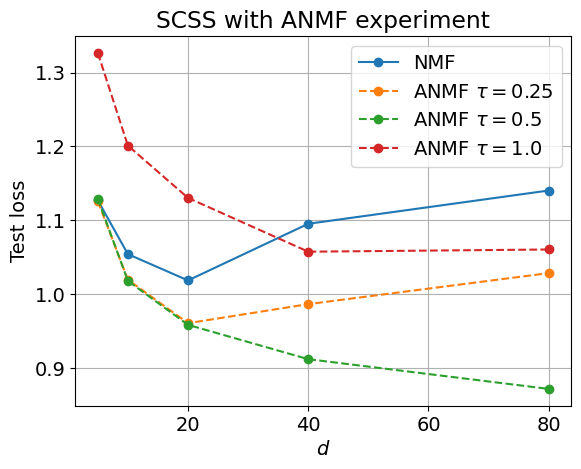

In [ ]:
plt.rcParams.update({'font.size': 14}) 
plt.plot(Ds, mean_norms_std[:,0], '-o', label = "NMF")
plt.plot(Ds, mean_norms_adv[:,2,0],'--o',label = "ANMF " + r"$\tau = $"  + str(taus[2]))
plt.plot(Ds, mean_norms_adv[:,1,0],'--o',label = "ANMF " + r"$\tau = $"  + str(taus[1]))
plt.plot(Ds, mean_norms_adv[:,0,0],'--o',label = "ANMF " + r"$\tau = $"  + str(taus[0]))
plt.xlabel(r"$d$")
plt.ylabel("Test loss")
plt.grid()
plt.legend()
plt.title("SCSS with ANMF experiment")
plt.savefig("figs/separation_experiment.png")
plt.show()

In [ ]:
nmf0 = prob_std.NMFs[0]; nmf1 = prob_std.NMFs[1] 
W_concat = np.concatenate((nmf0.W,nmf1.W), axis = 1)
d_concat = nmf0.d + nmf1.d
nmf_concat = NMF(d = d_concat, W = W_concat)

U_std_concat,H_nmf_concat = nmf_concat.transform(V)

H0 = H_nmf_concat[:nmf0.d,:]
H1 = H_nmf_concat[nmf0.d:,:]

U0 = np.dot(nmf0.W, H0)
U1 = np.dot(nmf1.W, H1)

norms_std = np.zeros((2,U_std_concat.shape[1]))
norms = np.zeros((2,U_std_concat.shape[1]))
for i in range(U_std_concat.shape[1]):
    u_wiener0 = V[:,i] * U0[:,i]/(U0[:,i] + U1[:,i] + 1e-8) 
    u_wiener1 = V[:,i] * U1[:,i]/(U0[:,i] + U1[:,i] + 1e-8)
    norms_std[0,i] = np.linalg.norm(u_wiener0 - U[:,0,i])
    norms_std[1,i] = np.linalg.norm(u_wiener1 - U[:,1,i])
    norms_std[0,i] = np.linalg.norm(U0[:,i] - U[:,0,i])
    norms_std[1,i] = np.linalg.norm(U1[:,i] - U[:,1,i])
    norms[0,i] = np.linalg.norm(U[:,0,i])
    norms[1,i] = np.linalg.norm(U[:,1,i])



In [ ]:
nmf0_adv = prob_adv.NMFs[0] ; nmf1_adv = prob_adv.NMFs[1]
W_concat_adv = np.concatenate((nmf0_adv.W,nmf1_adv.W), axis = 1)
d_concat_adv = nmf0_adv.d + nmf1_adv.d
nmf_concat_adv = NMF(d = d_concat_adv, W = W_concat_adv)

U_adv_concat,H_adv_concat = nmf_concat_adv.transform(V)

H0_adv = H_adv_concat[:nmf0_adv.d,:]
H1_adv = H_adv_concat[nmf0_adv.d:,:]

U0_adv = np.dot(nmf0_adv.W, H0_adv)
U1_adv = np.dot(nmf1_adv.W, H1_adv)

norms_adv = np.zeros((2,U0_adv.shape[1]))
for i in range(U_std_concat.shape[1]):
    u_wiener0 = V[:,i] * U0_adv[:,i]/(U0_adv[:,i] + U1_adv[:,i] + 1e-8) 
    u_wiener1 = V[:,i] * U1_adv[:,i]/(U0_adv[:,i] + U1_adv[:,i] + 1e-8) 
    norms_adv[0,i] = np.linalg.norm(u_wiener0 - U[:,0,i])
    norms_adv[1,i] = np.linalg.norm(u_wiener1 - U[:,1,i])
    norms_adv[0,i] = np.linalg.norm(U0_adv[:,i] - U[:,0,i])
    norms_adv[1,i] = np.linalg.norm(U1_adv[:,i] - U[:,1,i])

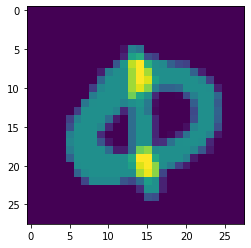

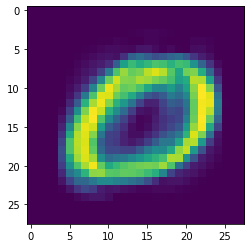

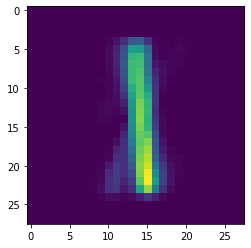

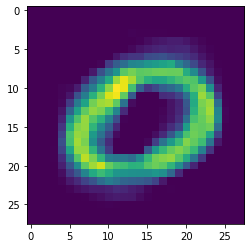

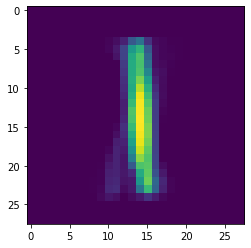

In [ ]:
i = 1
plt.imshow(V[:,i].reshape((28,28)))
plt.show()
plt.imshow(U0[:,i].reshape((28,28)))
plt.show()
plt.imshow(U1[:,i].reshape((28,28)))
plt.show()
plt.imshow(U0_adv[:,i].reshape((28,28)))
plt.show()
plt.imshow(U1_adv[:,i].reshape((28,28)))
plt.show()

2.4800838164778294
2.551876692166455
4.365986311882734


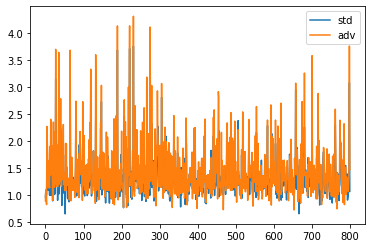

In [ ]:
print(np.mean(norms_std[0]))
print(np.mean(norms_adv[0]))
print(np.mean(norms))
plt.plot(norms_std[1], label = "std")
plt.plot(norms_adv[1], label = "adv")
plt.legend()

A few interesting things:
- It works! Without much work, we are able to train NMF basises. It's of course not super quick, because we have to do a lot of matrix-matrix products, but this can be sped up by GPUs.
- We note that the reconstructions are way worse at reconstructing $1$-digits, at the cost of being marginally worse at reconstructing $0$ digits. Normal NMF gives norms 306 and 396 for $0$ digits and $1$ digits respectively, while our NMF yields $318$ and $477$. "12 points" worse at reconstructing $0$ and $80$ points worse at reconstructing $1$. This is as expected.
- Squaring the norms (which yields a slightly nicer update for W), yields slightly worse or equivalent results (slightly worse at reconstructing $0$, but worse at $1$ as well.). This update is slightly faster because we don't have to calculate the norms and multiply the terms by the norms.
- We actually don't need to update the scaling of $W$, which is quite interesting. It's already stable. We can then simply scale $W$ by $\|W\|$ when we're finished to have Lipschitz-continuity.
- Observed infinity values one time. Don't know why that happened. Added safety division terms for this reason.
- After running many times for different random starting values, seems like the algorithm converges in a relatively stable way, which is quite cool. Should consider using better starting values (NNDSVD). 
- Want to see how well we are able to separate between signals.

(784, 800)
Average true: 3.774846361781524
Average false: 6.42213594105848
Wasserstein:  2.647289579276955


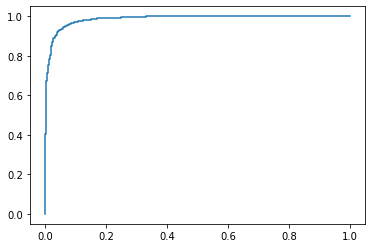

AUC: 0.986315625


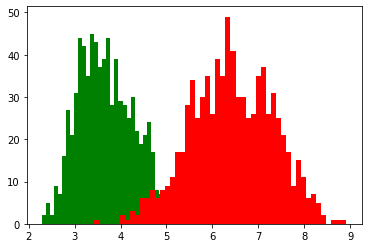

In [ ]:
# Apply to the test set to see if the potential regularization function
# Is good at splitting data
N = mnist.N_test
norms_true = np.zeros(N)
norms_false = np.zeros(N)
A = np.copy(mnist.x_test_lin[:,0,:])
reconst_true = NMF_proj(W,A.T,maxiter = 500)
A = np.copy(mnist.x_test_lin[:,1,:])
reconst_false = NMF_proj(W,A.T,maxiter = 500)
print(reconst_false.shape)
for i in range(N):
    norms_true[i] = np.linalg.norm(mnist.x_test_lin[i,0,:] - reconst_true[:,i],2)
    norms_false[i] = np.linalg.norm(mnist.x_test_lin[i,1,:] - reconst_false[:,i],2)

print("Average true:", np.average(norms_true))
print("Average false:", np.average(norms_false))

print("Wasserstein: ", wasserstein_distance(norms_true, norms_false))

y_true = np.concatenate((-1 * np.ones(mnist.N_test), 1 * np.ones(mnist.N_test)))
y_score = np.concatenate((norms_true, norms_false))

roc = roc_curve(y_true, y_score)
plt.plot(roc[0], roc[1])
plt.show()

print("AUC:", roc_auc_score(y_true,y_score))

plt.hist(norms_true,bins = 50, color = "green")
plt.hist(norms_false, bins = 50, color = "red")
plt.show()

In [ ]:
# NMF and SVD training
NMFs = []
Ws = []
Hs = []
SVDs = []
W_SVDs = []
H_SVDs = []

Ms = [0,1]
M_NMF = len(Ms)

# Number of basis vectors for each source
ds = [32, 32]

for i, m in enumerate(Ms):
    # NMF fitting function does not copy the data, so training is really slow
    # If the data is not stored well in memory. 
    A = np.copy(mnist.x_train_lin[:,m,:])

    # Number of basis vectors
    nmf = NMF(n_components = ds[i], max_iter = 200, tol = 1e-5)
    W = nmf.fit_transform(A)
    H = nmf.components_
    NMFs.append(nmf)
    Ws.append(W)
    Hs.append(H)

    # SVD
    svd = TruncatedSVD(n_components = ds[i])
    W_SVD = svd.fit_transform(A)
    H_SVD = svd.components_
    SVDs.append(svd)
    W_SVDs.append(W_SVD)
    H_SVDs.append(H_SVD)

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached

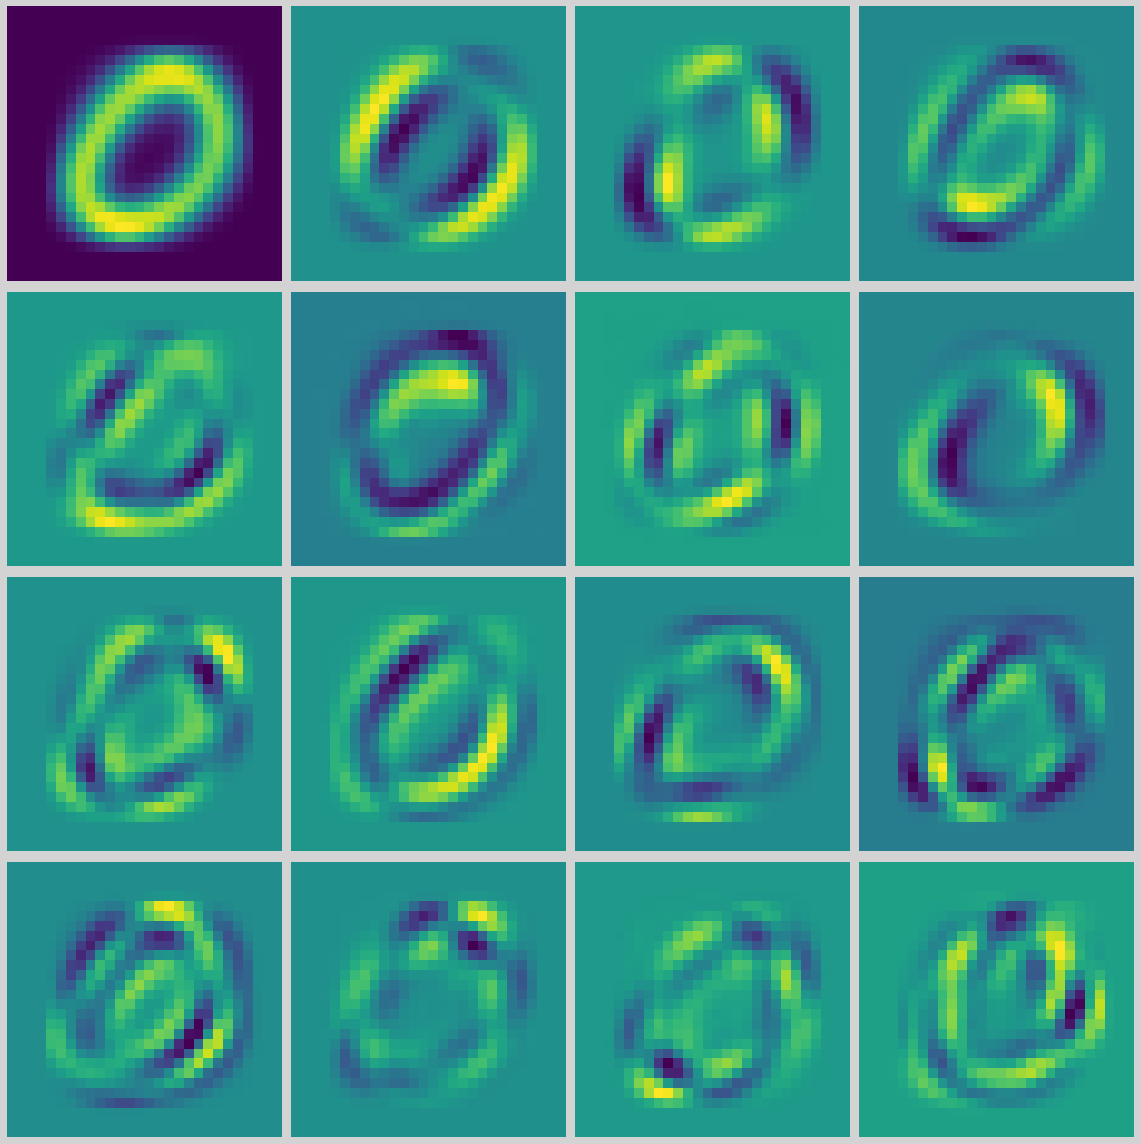

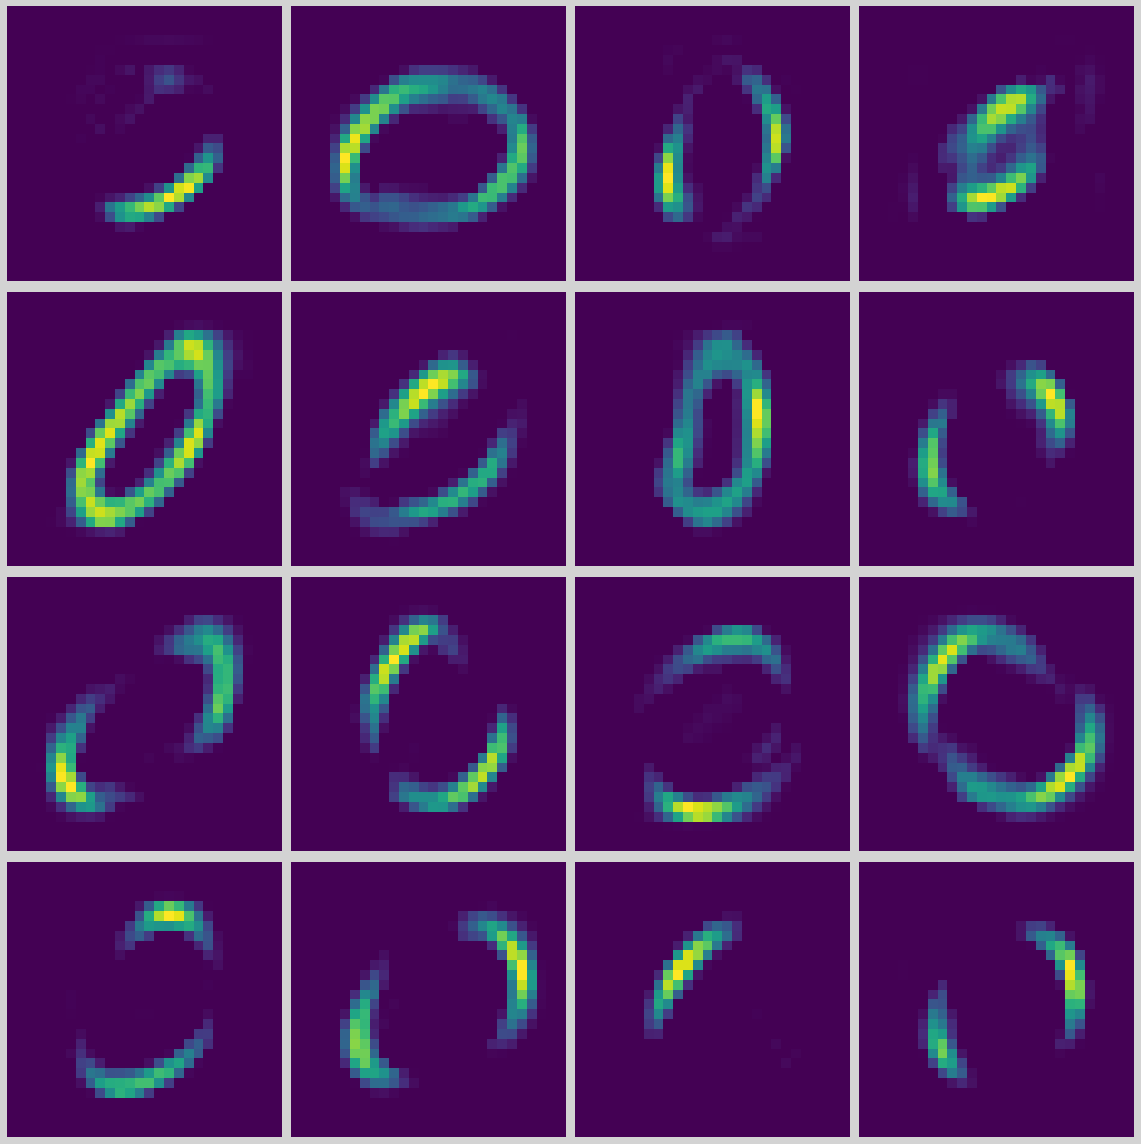

In [ ]:
# Plot the SVD and NMF basis vectors
# Note that the SVD produces more "global" vectors (and ones with negative components)
# While NMF produces more "local" vectors
plotimgs(H_SVDs[0].reshape((ds[0],28,28)), nplot = 4)
plotimgs(Hs[0].reshape((ds[0],28,28)), nplot = 4)

In [ ]:
print(np.linalg.norm(Ws[0] @ Hs[0] - U_r.T, 'fro'))
W_false = NMFs[0].transform(U_v.T)
print(np.linalg.norm(W_false @ Hs[0] - U_v.T, 'fro'))

306.94412
396.2778


Althogh this is not the main goal, it's interesting to see how well our proposed methods "classify" the different sources. That is, if we calculate
$$R(u) = \|u - \pi_{C(W)}\|_2^2$$
for the "true" (same class as $W$ was trained on) and "false" data (different class than what $W$ was trained on), how do the distributions look? In addition to plotting histograms, we calculate two metrics: The wasserstein distance, which quantifies how much "energy" it takes to "transform" one distribution into another. Large number means large distance. This number is kind of useless because it's not invariant to the scale. We also calculate the ROC curve and the AUC to see how well the regularization function is at classifying the data.

Average true: 3.439564127326012
Average false: 4.989766111373902
Wasserstein:  1.5502019840478898


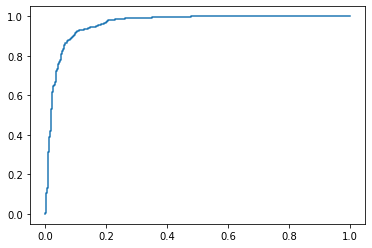

AUC: 0.9607984375


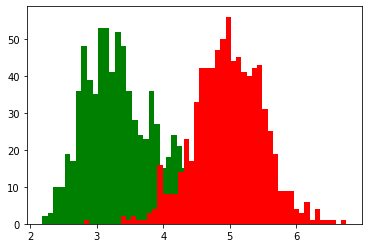

In [ ]:
# Apply to the test set to see if the potential regularization function
# Is good at splitting data
N = mnist.N_test
norms_true = np.zeros(N)
norms_false = np.zeros(N)

# What NMF basis to test on
m = 0

# Again, copying the data like this is neccessary because it is stored
# awkwardly in memory and NMF does not copy to align the data in memory 
if m == 0:
    A = np.copy(mnist.x_test_lin[:,0,:])
    W_true = NMFs[0].transform(A)
    A = np.copy(mnist.x_test_lin[:,1,:])
    W_false = NMFs[0].transform(A)
elif m == 1:
    A = np.copy(mnist.x_test_lin[:,0,:])
    W_false = NMFs[1].transform(A)
    A = np.copy(mnist.x_test_lin[:,1,:])
    W_true = NMFs[1].transform(A)

reconst_false = W_false @ Hs[0]
reconst_true = W_true @ Hs[0]

for i in range(N):
    norms_true[i] = np.linalg.norm(mnist.x_test_lin[i,0,:] - reconst_true[i],2)
    norms_false[i] = np.linalg.norm(mnist.x_test_lin[i,1,:] - reconst_false[i],2)

print("Average true:", np.average(norms_true))
print("Average false:", np.average(norms_false))

print("Wasserstein: ", wasserstein_distance(norms_true, norms_false))

y_true = np.concatenate((-1 * np.ones(mnist.N_test), 1 * np.ones(mnist.N_test)))
y_score = np.concatenate((norms_true, norms_false))

roc = roc_curve(y_true, y_score)
plt.plot(roc[0], roc[1])
plt.show()

print("AUC:", roc_auc_score(y_true,y_score))

plt.hist(norms_true,bins = 50, color = "green")
plt.hist(norms_false, bins = 50, color = "red")
plt.show()

Note that in the above example, for MNIST with Ms = [0,1], using m = 0 yields much better classifying results than m = 1. This is probably because with m = 1 the basis is becomes relatively "flexible", able to reproduce a large amount of signals. This perhaps illustrates the need to produce the basis vectors adverserially or discriminatively.

Below code snippets show splitting using SVD and NMF. We also calculate the wiener filtered solution and calculate the difference between the reconstructed solution and the original solutions.

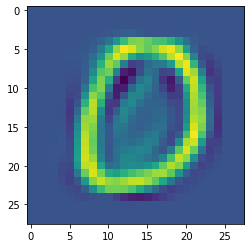

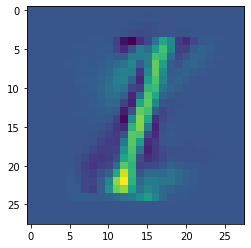

In [ ]:
# Splitting using SVD
H_SVD_concat = np.concatenate((H_SVDs[0], H_SVDs[1]))
W_SVD_concat = np.linalg.lstsq(H_SVD_concat.T, v.T, rcond = None)[0].T
reconst_SVD = W_SVD_concat @ H_SVD_concat
u0 = W_SVD_concat[:, :ds[0]] @ H_SVD_concat[:ds[0],:]
u1 = W_SVD_concat[:, ds[0]:] @ H_SVD_concat[ds[0]:,:]
u_0 = v * u0/(u0 + u1 + 1e-10)
u_1 = v * u1/(u0 + u1 + 1e-10)
plt.imshow(u0.reshape((28,28)))
plt.show()
plt.imshow(u1.reshape((28,28)))
plt.show()


Note that the wiener-filtered solutions perform better than the non-filtered versions. They are more detailed.

Below we attempt to solve the problem
$$ \min_{u_i \ge 0, i \in I} \|v - \sum c_i u_i \| + \sum_i \lambda_i \|u_i - \pi_{C(W_i)}(u_i)\|_2^2.$$
We add the non-negativity constraint on $u_i$ because solvers for $\pi_{C(W_i)}$ require non-negativity. In any case, we know that the resulting signal should only have positive components (which is part of why we apply NMF in the first place), so it is a reasonable assumption. 

Need the gradient of the regularization term, in particular, what is the derivative of $\pi_{C(W)}(u)$? 
(fill in) 


Projection residuals:
0.06020701489130276
0.02824225694735838
Norms:
[[[1.89682696]]

 [[0.57088593]]]
Norms rescaled:
[[[0.26779994]]

 [[0.26779994]]]


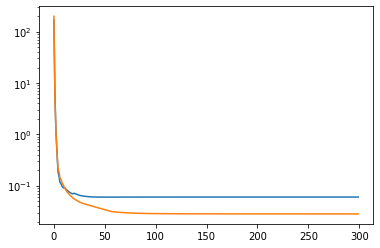

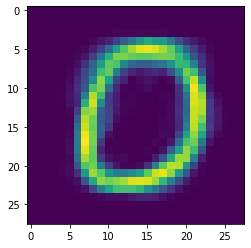

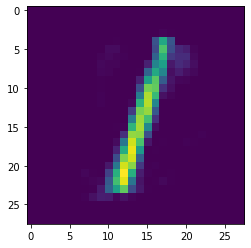

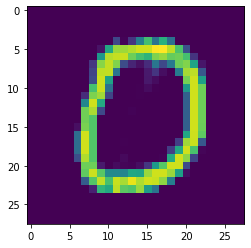

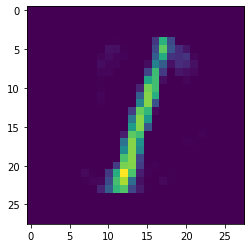

In [ ]:
# Gradient descent for NMF

i0 = 1; i1 = 0
cs = [0.5, 0.5]

v = (cs[0] * x_test_NMF[i0,0,:] + cs[1] * x_test_NMF[i1,1,:]).reshape((1,28*28)) #+ np.random.uniform(0.0,0.1, (1,28*28)).astype('float32')

us = np.random.uniform(0.0,1.0,(2,28*28)).astype('float32')
us_rescaled = np.copy(us)
lams0 = [5.0]
lams1 = [5.0]
maxiter = 300
norms = np.zeros((2,len(lams0), len(lams1)))
norms_rescaled = np.zeros((2,len(lams0), len(lams1)))
reslist = np.zeros((2,maxiter))
gradlist = np.zeros(maxiter)
step_length = 0.25
for k,lam0 in enumerate(lams0):
    for l,lam1 in enumerate(lams1):
        lams = np.array([lam0,lam1])
        for i in range(maxiter):
            gradsum = v - cs[0] * us[0] - cs[1] * us[1]
            for j in range(2):
                W_nn = NMFs[j].transform(us[j].reshape(1,28*28))
                NMF_proj = W_nn @ Hs[j]
                res = us[j] - NMF_proj  
                W = np.linalg.lstsq(Hs[j].T, res[0], rcond = None)
                nn_proj = np.maximum(W[0], 0.0) @ Hs[j]
                grad = res - nn_proj
                us[j] = np.maximum(us[j] - step_length * (-gradsum + lams[j] * grad) ,0.0)
                
                # Store the "projection" residual, i.e how much the 
                # solution deviates from iits projection
                reslist[j,i] = np.linalg.norm(res)**2

        us_rescaled[0] = v * us[0]/(us[0] + us[1] + 1e-10)
        us_rescaled[1] = v * us[1]/(us[0] + us[1] + 1e-10)

        # Multiply norms by $c$ to get same scaling as previous problem
        norms[0,k,l] = np.linalg.norm(c[0]*(us[0] - x_test_NMF[i0,0,:]))**2
        norms[1,k,l] = np.linalg.norm(c[1]*(us[1] - x_test_NMF[i1,1,:]))**2
        norms_rescaled[0,k,l] = np.linalg.norm(us_rescaled[0] - cs[0] * x_test_NMF[i0,0,:])**2
        norms_rescaled[1,k,l] = np.linalg.norm(us_rescaled[1] - cs[1] * x_test_NMF[i1,1,:])**2
print("Projection residuals:")
print(reslist[0,-1])
print(reslist[1,-1])
print("Norms:")
print(norms)
print("Norms rescaled:")
print(norms_rescaled)
#plt.semilogy(reslist[0,:])
#plt.semilogy(reslist[1,:])
#plt.show()
plt.imshow(us[0].reshape((28,28)))
plt.show()
plt.imshow(us[1].reshape((28,28)))
plt.show()
plt.imshow(us_rescaled[0].reshape((28,28)))
plt.show()
plt.imshow(us_rescaled[1].reshape((28,28)))
plt.show()